***Note: this is the Linearisation.ipynb notebook. The
PDF version "Linearisation of Biomolecular Systems"
is available [here](Linearisation.pdf).***

# Introduction
As discussed by <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>:

"The bond graph approach gives the set of *nonlinear* ordinary
differential equations describing the biomolecular system being modelled.
Linearisation of non-linear systems is a standard technique in control
engineering: as discussed by 
<cite data-cite="GooGraSal01">(Goodwin, Graebe and Salgado)</cite>, 
"The incentive to
try to approximate a nonlinear system by a linear model is that the
science and art of linear control is vastly more complete and simpler
than they are for the nonlinear case.". Nevertheless, it is important
to realise that conclusions drawn from linearisation can only be
verified using the full *nonlinear* equations."

This notebook tutorial examines the linearisation of bond graph models in the context of biomolecular systems using two simple examples:

1. An enzyme-catalysed reaction 
2. An enzyme-catalysed reaction with product removal

As will be seen, the first example is actually linear given the particular choce of chemostats; the second is non-linear the deviation from linearity is examined.

Linearisation of a dynamic system $\dot x = f(x,v)$ is with reference to a steady state defined by constant states $x=x_{ss}$ and constant flows $v=v_{ss}$ such that $f(x_{ss},v_{ss})=0$. In general, determination of steady-states is a difficult problem and can only be determined numerically. Some theoretical results are given by <cite data-cite="Gaw18">(Gawthrop, 2018)</cite>. In this tutorial, steady-states can be determined theoretically.

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Control systems package
import control as con

## Set quiet=False for verbose output
quiet = True

## Set slycot=True if slycot is installed (see control module)
slycot=True


# Example system: enzyme-catalysed reaction
The bond graph representation of the (reversible) enzyme-catalysed reaction is given by
<cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> and is discussed in the tutorial [ECR](ECR.ipynb).

The additional species $E0$ represents a reservoir of enzyme coupled to the ECR via the reaction $r0$. 
$E0$ is used as a chemostat to adjust the total amount of enzyme associated with the ECR.

{}


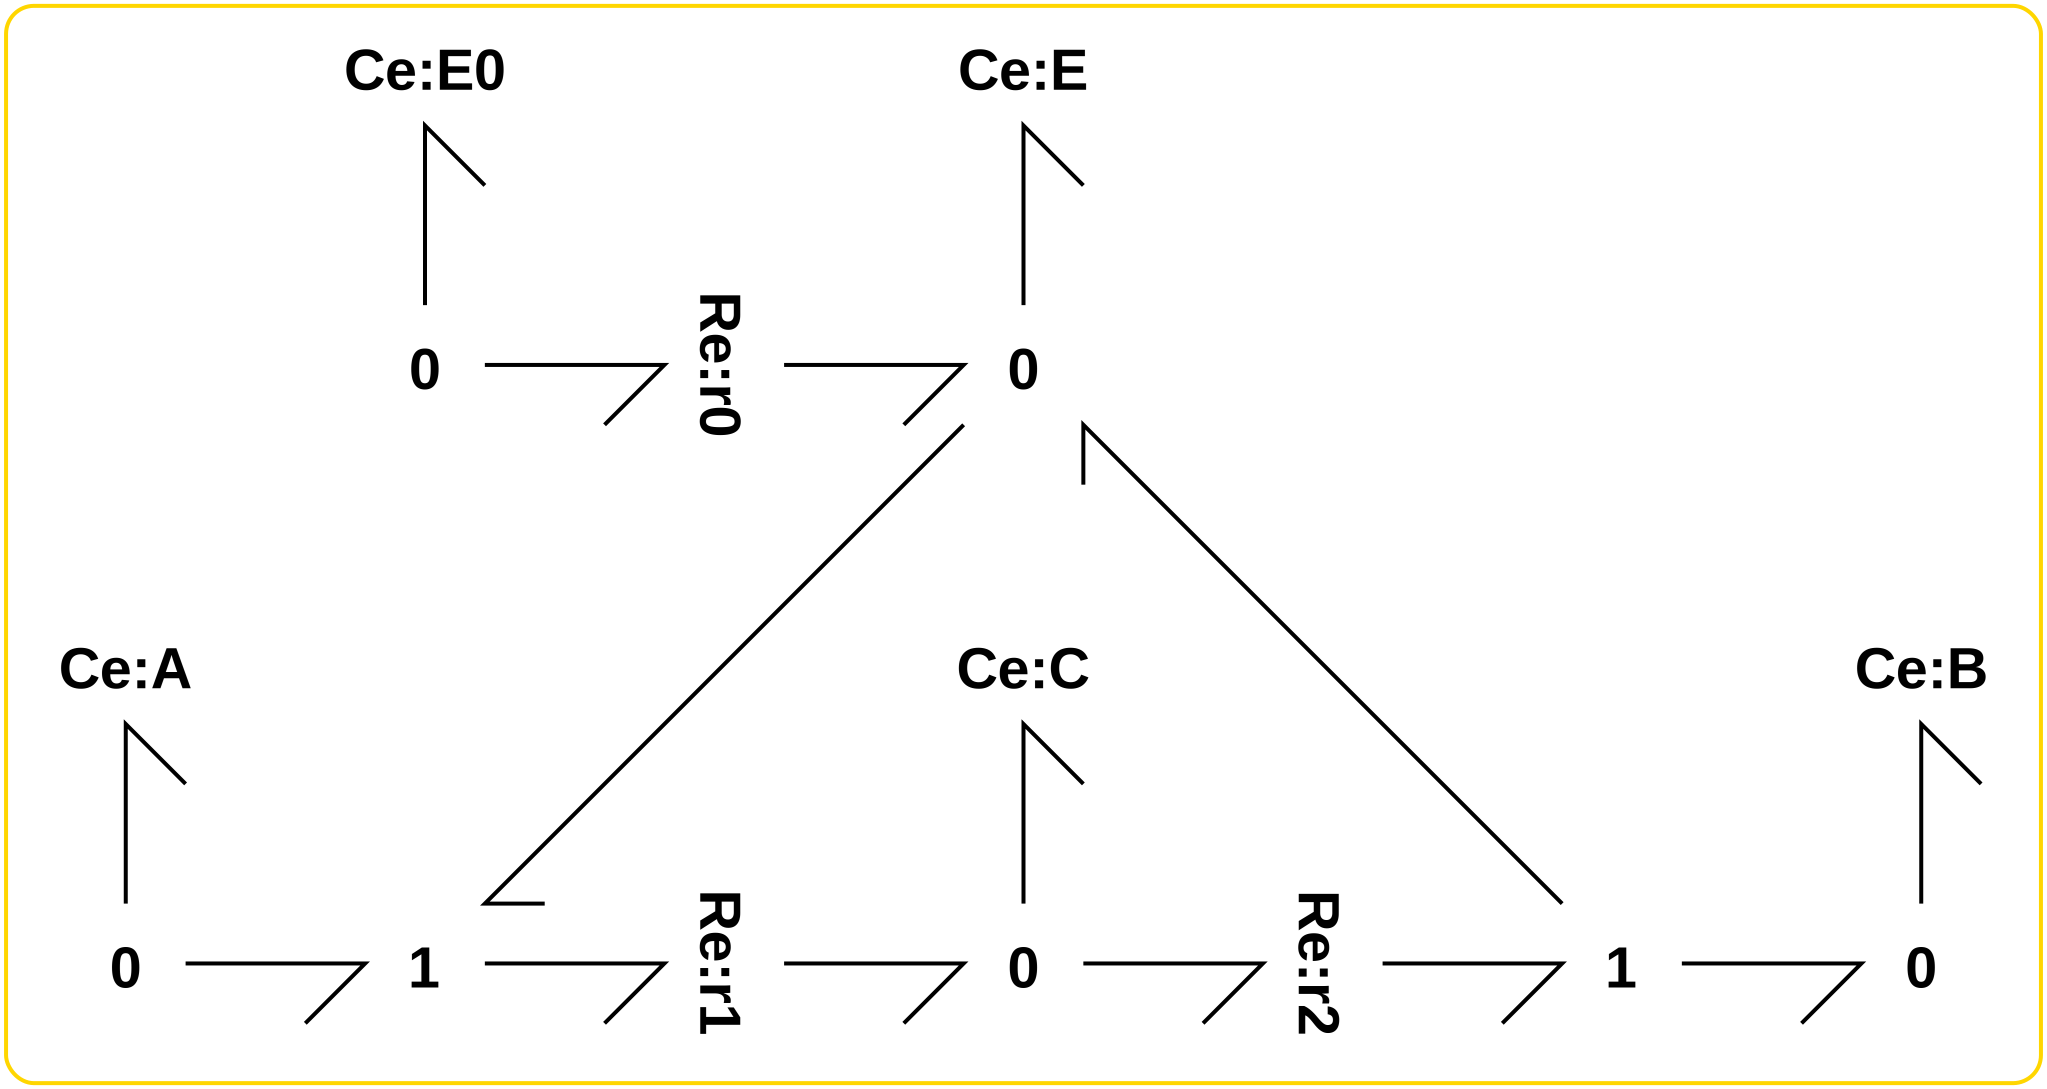

In [2]:
sbg.model('eRE_abg.svg')
import eRE_abg
disp.SVG('eRE_abg.svg')

## Stoichiometry & reactions

In [3]:
s = st.stoich(eRE_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s))

<IPython.core.display.Latex object>

## Chemostats and pathways


In [4]:
chemostats=['A','B','E0']
sc = st.statify(s,chemostats=chemostats)
sp =st.path(s,sc)
disp.Latex(st.sprintrl(sp))

<IPython.core.display.Latex object>

## Steady state.
In this particular case, the system steady state can be found theoretically assuming constant amounts of A and B
<cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>. Function ssECR does this:

In [5]:
def ssECR(x_A,x_B,e0=1,
             K_A = 1,K_B=1,K_C=1,K_E=1, K_E0 = 1e-3,
             kappa_r1 = 1,kappa_r2=1):
    """Theoretical steady state of Enzyme-catalysed Reactions
    """
    
    kappa_bar = (kappa_r1*kappa_r2)/(kappa_r1+kappa_r2)
    delta = K_A*x_A - K_B*x_B
    sigma = (kappa_r1*K_A*x_A + kappa_r2*K_B*x_B)/(kappa_r1 + kappa_r2)
    K_m = K_C/K_E
    
    v = kappa_bar*e0*K_C*delta/(K_m+sigma)
    x_E = e0/(1+(sigma/K_m))
    x_C = e0 - x_E
    x_E0 = (K_E/K_E0)*x_E
    x = np.array([x_A,x_B,x_C,x_E,x_E0])
    #x = [x_A,x_B,x_C,x_E,x_E0]
    return x,v

x_A = 2
x_B = 1
K_E0 = 1e-4
K_C = 1
x_ss,v_ss = ssECR(x_A,x_B,K_C=K_C,K_E0=K_E0)
print('x_ss =',x_ss)
print('v_ss =',v_ss)

x_ss = [2.e+00 1.e+00 6.e-01 4.e-01 4.e+03]
v_ss = 0.2


## Parameters

In [6]:
## Parameters
x_E0 = x_ss[4]

parameter = {}
parameter['K_E0'] = K_E0
parameter['K_C'] = K_C

## Linearisation
The function lin provides the linear transfer function sys in control toolbox format and puts the corresponding state-space matrices $a$, $b$, $c$ and $d$ into the data structure sc where $\dot{x}=ax + bu$ and $y = cx + du$
The system is the *reduced* form <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>.
The output $y$ corresponds to the flows $V$, the input $u$ to the chemostats $X_{chemo}$ and $x$ to the reduced state.
In this case
\begin{align}
y = V&= \begin{pmatrix}
    V_{r0}\\
    V_{r1}\\
    V_{r2}\\
\end{pmatrix}\\
u= X_{chemo}&= \begin{pmatrix}
    X_{A}\\
    X_{B}\\
    X_{E0}\\
\end{pmatrix}\\
x&= \begin{pmatrix}
    X_{C}\\
    X_{E}\\
\end{pmatrix}
\end{align}

It also gives the symbolic matrix dv/dx relating incremental flows to incremental states where the states $X$ are:
\begin{align}
X&= \begin{pmatrix}
    X_{A}\\
    X_{B}\\
    X_{C}\\
    X_{E}\\
    X_{E0}\\
\end{pmatrix}
\end{align}


In [7]:
## imp.reload(st)
sys = st.lin(s,sc,x_ss=x_ss,parameter=parameter,quiet=quiet)

In [8]:
disp.Latex(st.sprintl(sc,'dvdx'))

<IPython.core.display.Latex object>

In [9]:
disp.Latex(st.sprintl(sc,'a'))

<IPython.core.display.Latex object>

In [10]:
disp.Latex(st.sprintl(sc,'b'))

<IPython.core.display.Latex object>

In [11]:
disp.Latex(st.sprintl(sc,'c'))

<IPython.core.display.Latex object>

In [12]:
disp.Latex(st.sprintl(sc,'d'))

<IPython.core.display.Latex object>

## Pole/zero analysis
One advantage of dealing with linear systems is the possibility of using standard control system methods
<cite data-cite="GooGraSal01">(Goodwin, Graebe and Salgado)</cite>. One such method is examining the poles and zeros of the system transfer function relating inputs and outputs of interest. In this case, the transfer function relating input $X_{E0}$ to output $V_{r2}$ is examined.

NB con.zero requires slycot to be installed; set slycot=False if slycot is not installed.

Note that the positive zero ($s=1$) corresponds to the initial negative response of the flow - this is an non-minimum phase system

In [13]:
i_E0 = chemostats.index('E0')
reaction = sc['reaction']
i_r = reaction.index('r2')
np.set_printoptions(precision=2)
aa = sc['a']
bb = np.array([sc['b'][:,i_E0]]).T
cc = sc['c'][i_r,:]
dd = sc['d'][i_r,i_E0]
siso = con.ss(aa,bb,cc,dd)
np.set_printoptions(precision=2)
gain = x_E0*con.dcgain(siso)
print('System gain = {0:.2f}'.format(gain))
print('System poles = ',con.pole(siso))
if slycot:
    ## This needs slycot
    print('System zeros = ',np.real(con.zero(siso)))

System gain = 0.20
System poles =  [-0.35+0.j -5.65+0.j]
System zeros =  [1.]


## Simulation
1. As simulation starts at a steady-state value, states and flows remain constant until the chemostat E0 changes at time $t_0=5$.
2. For each fixed chemostat value, the non-linear system is actually linear (but with parameters dependent on the steady-state).
3. The flow in reaction r2 is the same for both linear and non-linear simulation.
4. The flow in reaction r2 increases by the gain=0.2.

NON-LINEAR SIMULATION
Setting K_C to 1
Setting K_E0 to 0.0001


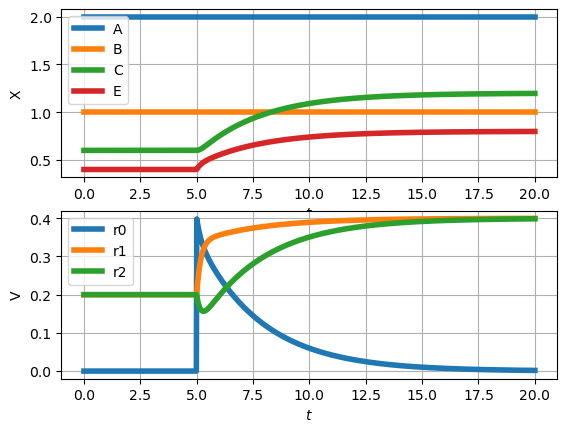

LINEAR SIMULATION
Setting K_C to 1
Setting K_E0 to 0.0001
Setting K_C to 1
Setting K_E0 to 0.0001


/home/peterg/WORK/Research/SystemsBiology/lib/python/stoich.py:140: RuntimeWarning: divide by zero encountered in log
  lx_i = np.log(xx_i)
/home/peterg/WORK/Research/SystemsBiology/lib/python/stoich.py:1932: RuntimeWarning: invalid value encountered in matmul
  Phi = -phi@N
/home/peterg/WORK/Research/SystemsBiology/lib/python/stoich.py:1964: RuntimeWarning: invalid value encountered in multiply
  P_Re = Phi*V
/home/peterg/WORK/Research/SystemsBiology/lib/python/stoich.py:1967: RuntimeWarning: invalid value encountered in multiply
  P_C = phi*dX


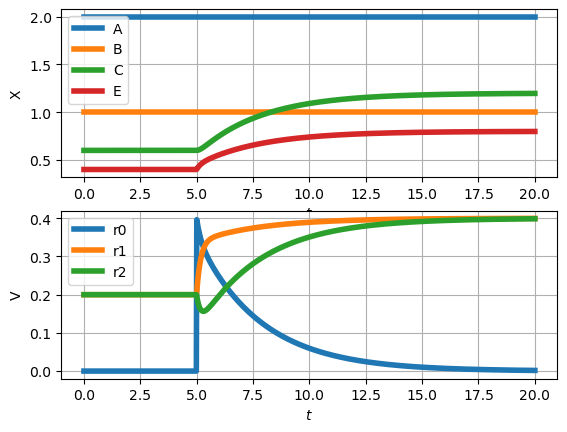

In [14]:
## imp.reload(st)
##Time
t_max = int(20)
t = np.linspace(0,t_max,1000)
t_0 = 5

## Chemostat
x_chemo =     '{0}*(1+np.heaviside(t-{1},1))'.format(str(x_E0),str(t_0))
x_chemo_lin = '{0}*(np.heaviside(t-{1},1))'.format(str(x_E0),str(t_0))

## Simulate
print('NON-LINEAR SIMULATION')
#X0 = x_ss
X_chemo = {'E0':x_chemo}
ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=x_ss,X_chemo=X_chemo,quiet=False)
st.plot(s,ndat,species=['A','B','C','E'])

print('LINEAR SIMULATION')
#X0 = x_ss
X_chemo = {'E0':x_chemo_lin}
V0 = [0,v_ss,v_ss] # Steady-state flows
ldat = st.sim(s,sc=sc,t=t,linear=True,V0=V0,parameter=parameter,X0=x_ss,X_chemo=X_chemo,quiet=False)
st.plot(s,ldat,species=['A','B','C','E'])
#st.plot(s,ldat,species=[])


### Compare linear and nonlinear

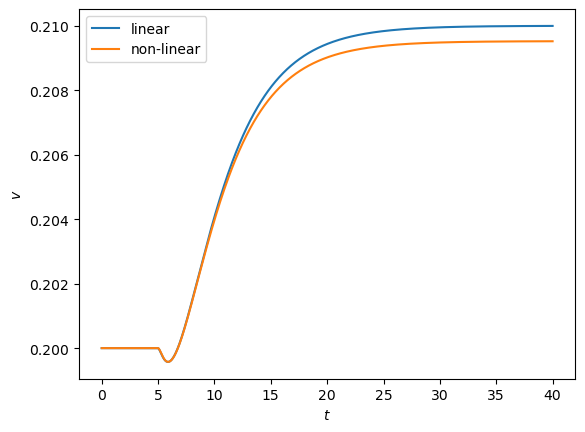

In [28]:
def compare(ndat,ldat,v_ss,gain,i):

    v_1_l = ldat['V'][:,i]
    v_1_n = ndat['V'][:,i]

    # ax = plt.gca()  # gca stands for 'get current axis'
    plt.plot(t,v_1_l,label='linear')
    plt.plot(t,v_1_n,label='non-linear')
 
    plt.xlabel('$t$')
    plt.ylabel('$v$')
    plt.legend()
    plt.grid
    #plt.show()
    
compare(ndat,ldat,v_ss,gain,i_r)
# compare(ndat,ldat,v_ss,gain,i_r)

# Example system: enzyme-catalysed reaction with product removal

{}


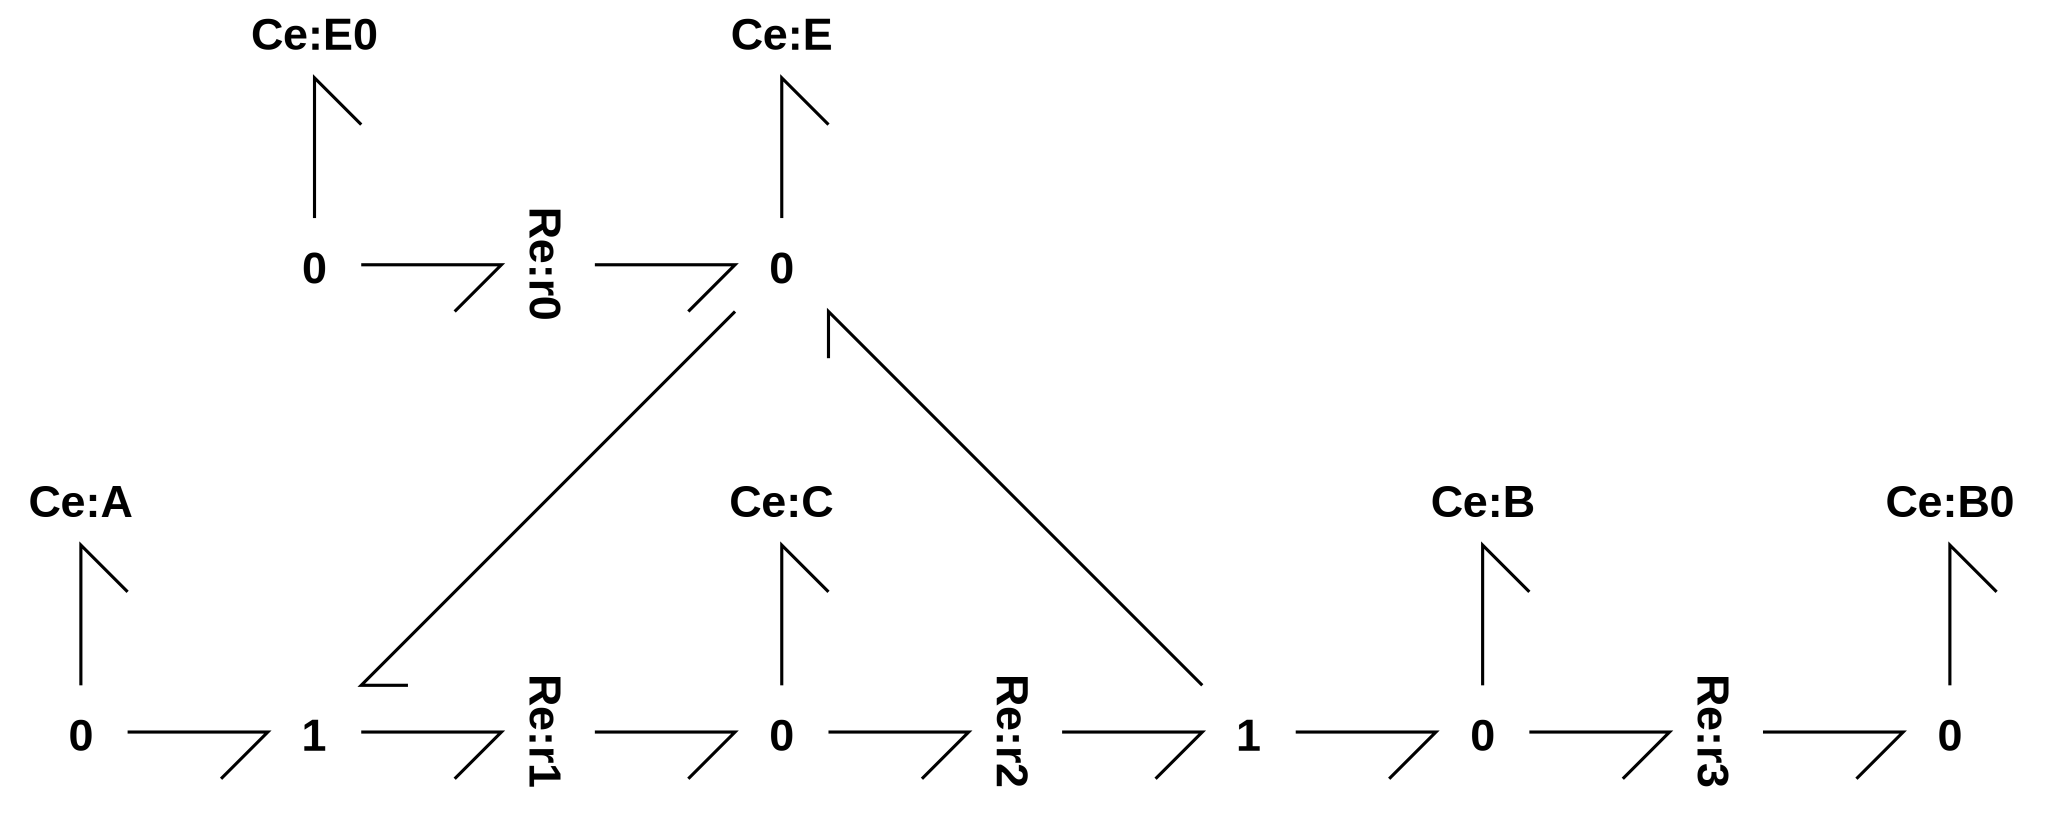

In [16]:
## imp.reload(st)
sbg.model('eREr_abg.svg')
import eREr_abg
disp.SVG('eREr_abg.svg')

## Stoichiometry

In [17]:
s = st.stoich(eREr_abg.model(),quiet=quiet)
print(s['species'])
chemostats=['A','B0','E0']
disp.Latex(st.sprintrl(s))
sc = st.statify(s,chemostats=chemostats)

['A', 'B', 'B0', 'C', 'E', 'E0']


## Parameters

In [18]:
## Parameters
# x_E0 = x_ss[4]
# x_A = 2
# x_B = 1

parameter = {}
parameter['K_E0'] = K_E0
parameter['K_C'] = K_C



## Steady state.
As a special case, the amount of B0 is taken to be very small and the parameter $\kappa_3=v_{ss}$. This gives the same steady states a the previous section.

In [19]:
## Steady states for ECR
x_ss,v_ss = ssECR(x_A,x_B,K_C=K_C,K_E0=K_E0)

## Steady states for this examples
X_ss = np.array([x_ss[0],x_ss[1],1e-10,x_ss[2],x_ss[3],x_ss[4]])
#print(X_ss)
V_ss = np.array([0,v_ss,v_ss,v_ss])
#print(V_ss)

## Set appropriate  kappa3
kappa_r3 = v_ss
parameter['kappa_r3'] = kappa_r3

## Linearisation
The function lin provides the linear transfer function sys in control toolbox format and puts the corresponding state-space matrices $a$, $b$, $c$ and $d$ into the data structure sc where $\dot{x}=ax + bu$ and $y = cx + du$
The system is the *reduced* form <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite>.
The output $y$ corresponds to the flows $V$, the input $u$ to the chemostats $X_{chemo}$ and $x$ to the reduced state.
In this case
\begin{align}
y = V&= \begin{pmatrix}
    V_{r0}\\
    V_{r1}\\
    V_{r2}\\
    V_{r3}\\
\end{pmatrix}\\
U = X_{chemo} &= \begin{pmatrix}
    X_{A}\\
    X_{B0}\\
    X_{E0}\\
\end{pmatrix}\\
x&= \begin{pmatrix}
    X_{B}\\
    X_{C}\\
    X_{E}\\
\end{pmatrix}
\end{align}


It also gives the symbolic matrix dv/dx relating incremental flows to incremental states where the states $X$ are:
\begin{align}
X&= \begin{pmatrix}
    X_{A}\\
    X_{B}\\
    X_{B0}\\
    X_{C}\\
    X_{E}\\
    X_{E0}\\
\end{pmatrix}
\end{align}




In [20]:
## imp.reload(st)
sys = st.lin(s,sc,x_ss=X_ss,parameter=parameter)
disp.Latex(st.sprintl(sc,'dvdx'))

Setting K_C to 1
Setting K_E0 to 0.0001
Setting kappa_r3 to 0.2


<IPython.core.display.Latex object>

In [21]:
disp.Latex(st.sprintl(sc,'a'))

<IPython.core.display.Latex object>

In [22]:
disp.Latex(st.sprintl(sc,'b'))

<IPython.core.display.Latex object>

In [23]:
disp.Latex(st.sprintl(sc,'c'))

<IPython.core.display.Latex object>

In [24]:
disp.Latex(st.sprintl(sc,'d'))

<IPython.core.display.Latex object>

## Pole/zero analysis
One advantage of dealing with linear systems is the possibility of using standard control system methods
<cite data-cite="GooGraSal01">(Goodwin, Graebe and Salgado)</cite>. One such method is examining the poles and zeros of the system transfer function relating inputs and outputs of interest. In this case, the transfer function relating input $X_{E0}$ to output $V_{r2}$ is examined.


NB con.zero requires slycot to be installed; set slycot=False if slycot is not installed.

Note that the positive zero ($s=1$) corresponds to the initial negative response of the flow - this is an non-minimum phase system.

In [25]:
i_E0 = chemostats.index('E0')
reaction = sc['reaction']
i_r = reaction.index('r3')
np.set_printoptions(precision=2)
aa = sc['a']
bb = np.array([sc['b'][:,i_E0]]).T
cc = sc['c'][i_r,:]
dd = sc['d'][i_r,i_E0]
siso = con.ss(aa,bb,cc,dd)
np.set_printoptions(precision=2)
gain = x_E0*con.dcgain(siso)
print('System gain = {0:.2f}'.format(gain))
print('System poles = ',con.pole(siso))
if slycot:
    ## This needs slycot
    print('System zeros = ',np.real(con.zero(siso)))

System gain = 0.10
System poles =  [-5.8 +0.j -0.56+0.j -0.25+0.j]
System zeros =  [1.]


## Simulation
1. As simulation starts at a steady-state value, states and flows remain constant until the chemostat E0 changes at time $t_0=5$.
2. For each fixed chemostat value, the non-linear system leads to an approximate linear system (but with parameters dependent on the steady-state).
3. The flow in reaction r2 is the different for linear and non-linear simulation, but the difference is smaller for smaller step changes in $x_{E0}$.
4. In the linear case, the flow in reaction r2 increases by gain=0.1 multiplied by the step.
5. In both linear and non-linear cases, the flow in reaction r1 is zero in the steady-state. Thus flow from the input source E0 is transient; in other words *retroactivity* is zero in the steady state.

NON-LINEAR SIMULATION: Step = 1


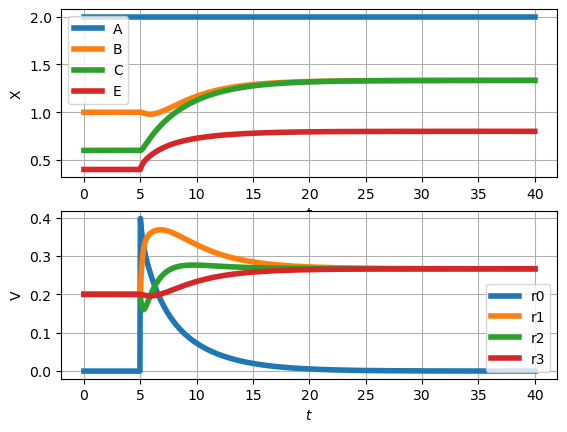

LINEAR SIMULATION: Step = 1


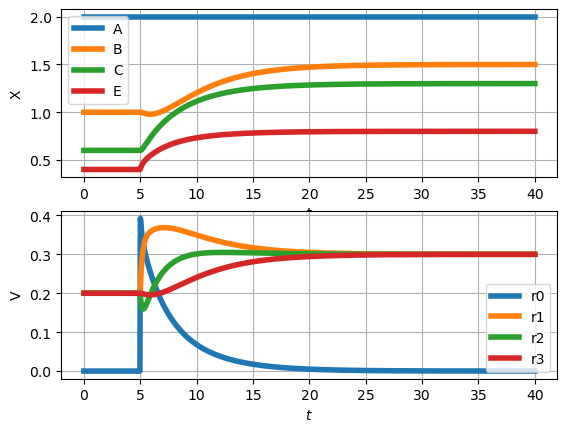

COMPARE LINEAR & NONLINEAR: Step = 1


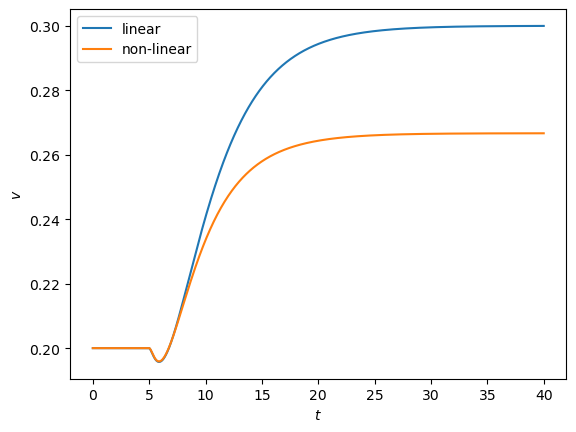

NON-LINEAR SIMULATION: Step = 0.1


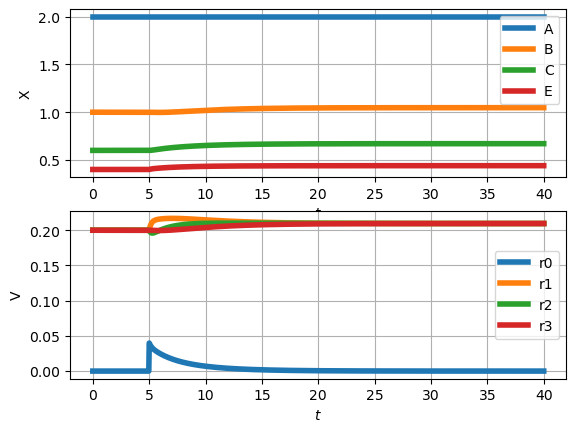

LINEAR SIMULATION: Step = 0.1


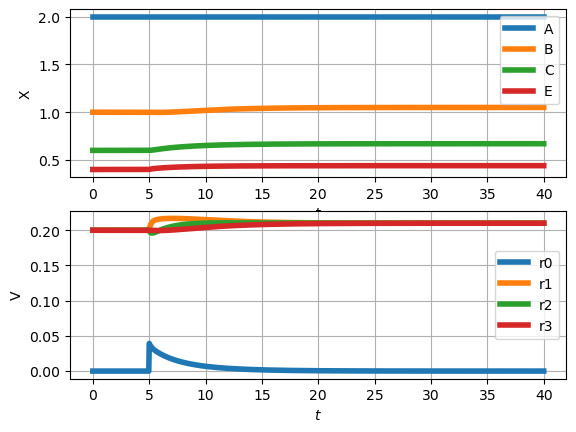

COMPARE LINEAR & NONLINEAR: Step = 0.1


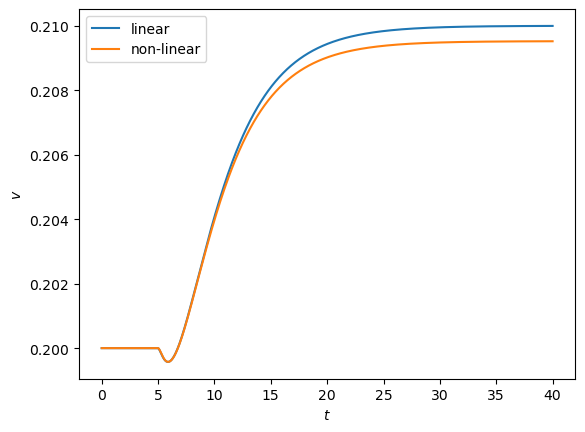

In [26]:
## imp.reload(st)

##Time
t_max = int(40)
t = np.linspace(0,t_max,1000)
t_0 = 5

for step in [1,0.1]:
    
    ## Chemostat
    #step = 1
    x_chemo =     '{0}*(1+{2}*np.heaviside(t-{1},1))'.format(str(x_E0),str(t_0),str(step))
    x_chemo_lin = '{0}*({2}*np.heaviside(t-{1},1))'.format(str(x_E0),str(t_0),str(step))

    ## Simulate
    print('NON-LINEAR SIMULATION: Step = '+str(step))
    #X0 = x_ss
    X_chemo = {'E0':x_chemo}
    ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X_ss,X_chemo=X_chemo,quiet=quiet)
    st.plot(s,ndat,species=['A','B','C','E'])

    print('LINEAR SIMULATION: Step = '+str(step))
    #X0 = x_ss
    X_chemo = {'E0':x_chemo_lin}
    V0 = [0,v_ss,v_ss] # Steady-state flows
    ldat = st.sim(s,sc=sc,t=t,linear=True,V0=V_ss,parameter=parameter,X0=X_ss,X_chemo=X_chemo,quiet=quiet)
    st.plot(s,ldat,species=['A','B','C','E'])

    print('COMPARE LINEAR & NONLINEAR: Step = '+str(step))
    compare(ndat,ldat,v_ss,step*gain,i_r)
    